In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data

from models.seir import SEIR_Testing, SEIRHD, SEIR_Movement, SEIR_Movement_Testing, SEIRHD_Severity, SEIRHD_Bed

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv
from utils.create_report import create_report
from utils.loss import Loss_Calculator
from viz import plot_forecast

## Load Covid19india Data

In [3]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

In [4]:
predictions_dict = {}

## Select Districts to fit on

In [5]:
districts_to_show = [('Maharashtra', 'Mumbai')]

## Get Variable Params

In [6]:
variable_param_ranges = {
    'lockdown_R0': (1, 1.5),
    'T_inc': (4, 5),
    'T_inf': (3, 4),
    'T_recov_hq': (20, 30),
    'T_recov_non_oxy': (20, 40),
    'T_recov_oxy': (20, 40),
    'T_recov_icu': (20, 60),
    'T_recov_vent': (20, 60),
    'P_non_oxy': (0, 0.4),
    'P_oxy': (0, 0.4),
    'P_icu': (0, 0.2),
    'P_vent': (0, 0.2),
    'P_fatal': (0, 0.2),
    'E_hosp_ratio': (0, 2),
    'I_hosp_ratio': (0, 1)
}
variable_param_ranges = get_variable_param_ranges(variable_param_ranges)

## Assign Filename var

In [7]:
filename = '../../data/data/mumbai/case_summary_expanded_1406.csv'

## Perform M1 and M2 fits

Performing m1 fit ..
splitting data ..
splitting data ..
train
           state district       date  total_infected  hospitalised  recovered  \
9   Maharashtra   Mumbai 2020-06-03         43336.6       24205.8    17713.4   
10  Maharashtra   Mumbai 2020-06-04         44586.8       24806.6    18311.6   
11  Maharashtra   Mumbai 2020-06-05         45899.4       25269.0    19108.2   
12  Maharashtra   Mumbai 2020-06-06         47219.6       25619.4    20021.4   
13  Maharashtra   Mumbai 2020-06-07         48454.4       25826.8    20990.2   

    deceased  stable_asymptomatic  stable_symptomatic  critical    ccc2  \
9     1417.4              16510.8              6699.4     995.6  4456.0   
10    1468.6              17069.6              6753.2     983.8  4508.6   
11    1522.2              17520.6              6784.4     964.0  4520.0   
12    1578.8              17866.0              6804.0     949.4  4548.6   
13    1637.4              18049.0              6833.6     944.2  4505.8   

    

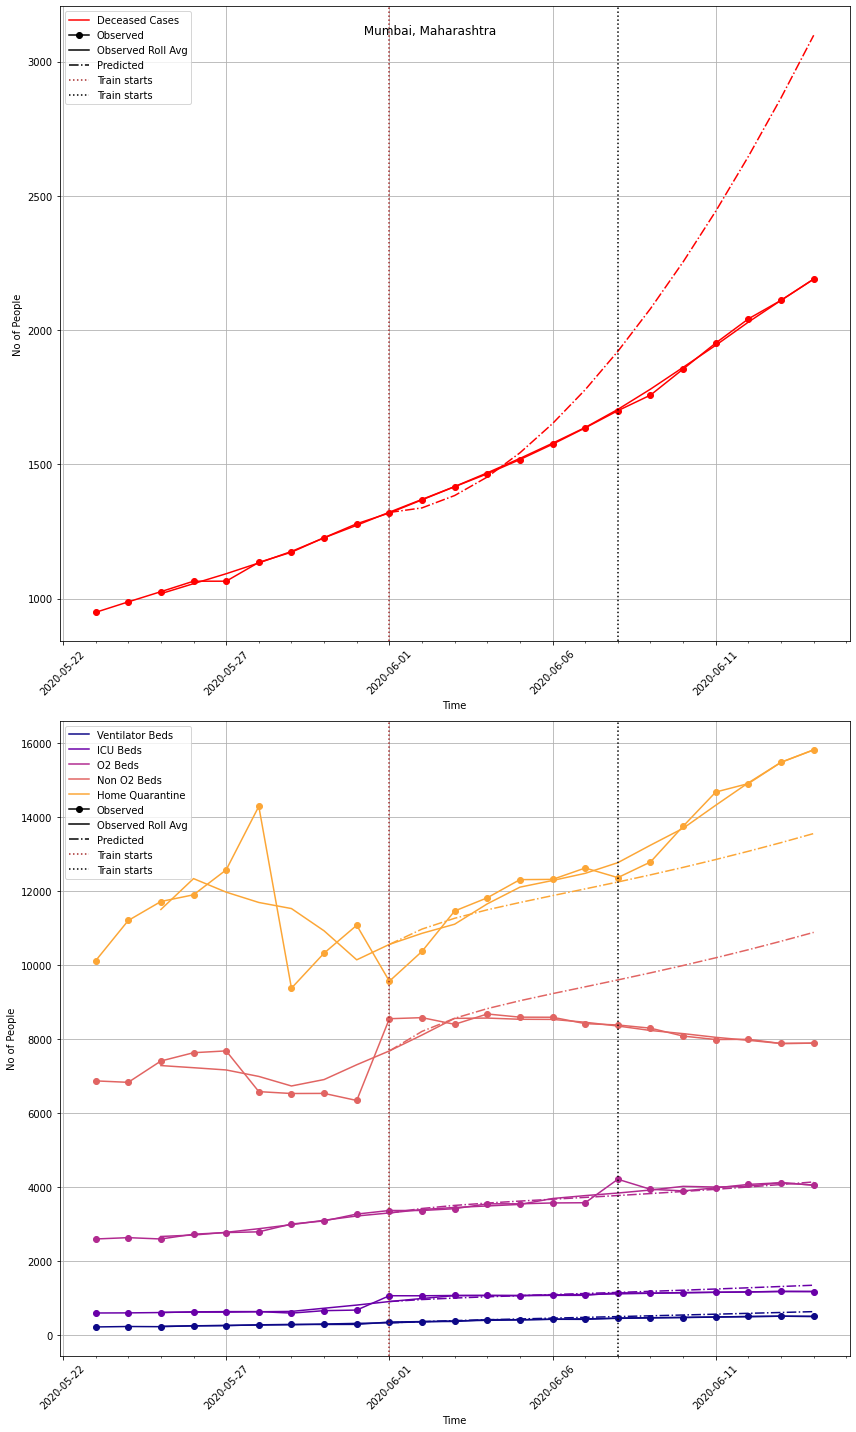

In [8]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(
        dataframes, state, district, data_from_tracker=True, granular_data=True, filename=filename, #Data
        model=SEIRHD_Bed, variable_param_ranges=variable_param_ranges, #Choose Model and Ranges
        train_period=7, val_period=7, num_evals=1000, initialisation='intermediate', #Optimisation related parameters
        which_compartments=['deceased', 'hq', 'non_o2_beds', 'o2_beds', 'icu', 'ventilator'], #Compartments to Apply Loss on 
        smooth_jump=False, smoothing_length=33, smoothing_method='weighted') #Smoothing
    
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
#     predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

In [9]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_loss']

,train,val
deceased,2.83879,20.4669
hq,4.72996,10.5256
non_o2_beds,5.96716,20.7577
o2_beds,2.19479,3.00476
icu,6.3733,7.00857
ventilator,4.99056,13.3738


In [10]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['best_params']

{'E_hosp_ratio': 0.1727915559763606,
 'I_hosp_ratio': 0.43293488821652837,
 'P_fatal': 0.1709071547395841,
 'P_icu': 0.018695529934545013,
 'P_non_oxy': 0.13044878977109892,
 'P_oxy': 0.09453337293818476,
 'P_vent': 0.014489330122234878,
 'T_inc': 4.320536148786453,
 'T_inf': 3.231892966000209,
 'T_recov_hq': 26.111125327984002,
 'T_recov_icu': 20.037616046537607,
 'T_recov_non_oxy': 35.5807330930384,
 'T_recov_oxy': 24.41584373558804,
 'T_recov_vent': 49.054555223775914,
 'lockdown_R0': 1.2313898375139576}

In [112]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_prediction'].iloc[:7, :].loc[:, ['date', 'critical']]

,date,critical
0,2020-06-01,1000
1,2020-06-02,993
2,2020-06-03,984
3,2020-06-04,973
4,2020-06-05,963
5,2020-06-06,953
6,2020-06-07,943


In [113]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_train'].iloc[-7:, :].loc[:, ['date', 'critical']]

,date,critical
7,2020-06-01,1000.2
8,2020-06-02,998.0
9,2020-06-03,995.6
10,2020-06-04,983.8
11,2020-06-05,964.0
12,2020-06-06,949.4
13,2020-06-07,944.2


## Create Master Loss Dataframe

### M1 Loss DataFrame

In [ ]:
lc = Loss_Calculator()

In [ ]:
lc.create_loss_dataframe_master(predictions_dict, 'm1')

### M2 Loss DataFrame

In [ ]:
lc.create_loss_dataframe_master(predictions_dict, 'm2')

## Plot Forecasts

In [ ]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=True, error_bars=True)

## Create Report

In [ ]:
for region in predictions_dict.keys():
    create_report(predictions_dict[region])

## Create and Save Output CSV

In [ ]:
df_output = create_all_csvs(predictions_dict, icu_fraction=0.02)

In [ ]:
write_csv(df_output)